Importing required libraries

In [ ]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

Reading dataset and pre-processing

In [5]:
data_set = pd.read_csv("/content/drive/MyDrive/spam.csv",encoding="ISO-8859-1")

In [7]:
data_set.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
data_set.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [11]:
data_set.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
duplicatedRow = data_set[data_set.duplicated()]
print(duplicatedRow[:5])

      v1                                                 v2
102  ham  As per your request 'Melle Melle (Oru Minnamin...
153  ham  As per your request 'Melle Melle (Oru Minnamin...
206  ham  As I entered my cabin my PA said, '' Happy B'd...
222  ham                             Sorry, I'll call later
325  ham                   No calls..messages..missed calls


In [17]:
data_set.groupby('v1').describe().T

v1                            ham  \
v2 count                     4825   
   unique                    4516   
   top     Sorry, I'll call later   
   freq                        30   

v1                                                      spam  
v2 count                                                 747  
   unique                                                653  
   top     Please call our customer service representativ...  
   freq                                                    4

In [19]:
# Get all the ham and spam emails
ham_msg = data_set[data_set.v1 =='ham']
spam_msg = data_set[data_set.v1=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.v2.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.v2.to_numpy().tolist())

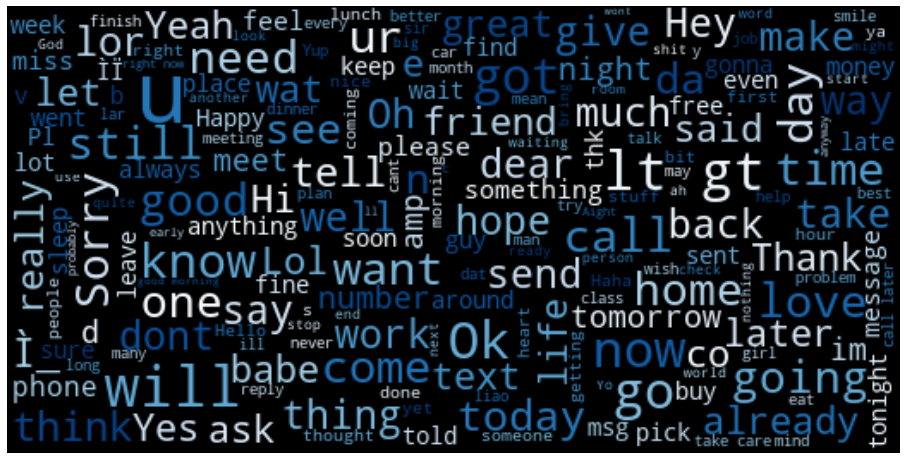

In [20]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

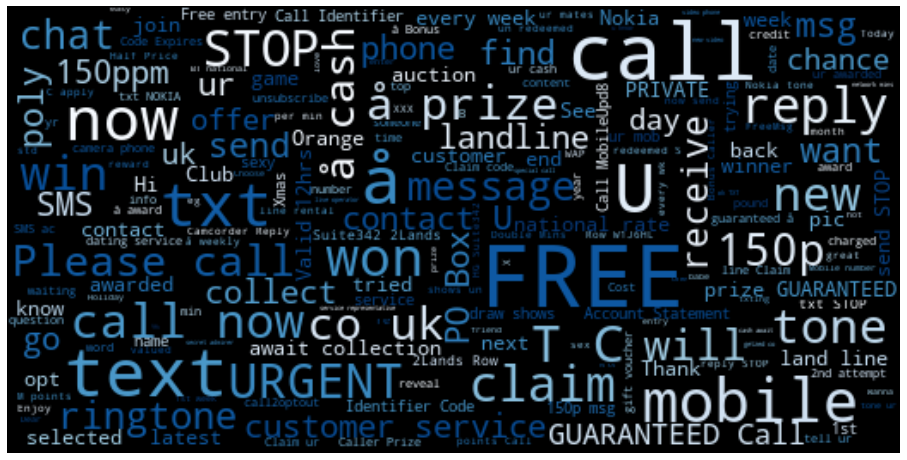

In [22]:
#wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

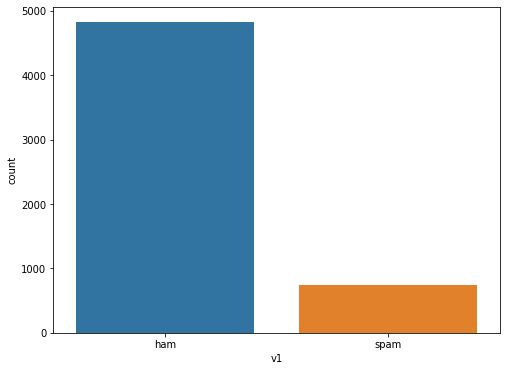

In [24]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(data_set.v1)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 # 15.48%

In [25]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

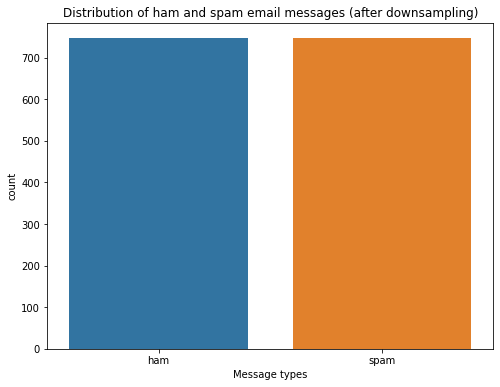

In [26]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.v1)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [27]:
# Get length column for each text
msg_df['text_length'] = msg_df['v2'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('v1').mean()
labels

,text_length
v1,
ham,69.626506
spam,138.866131


In [28]:
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['v1'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['v2'], msg_label, test_size=0.2, random_state=434)

In [29]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [30]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [31]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'now': 11,
 'is': 12,
 '2': 13,
 'and': 14,
 'free': 15,
 'in': 16,
 'or': 17,
 'have': 18,
 'on': 19,
 'ur': 20,
 'of': 21,
 'txt': 22,
 'with': 23,
 'are': 24,
 '4': 25,
 'from': 26,
 'me': 27,
 'text': 28,
 'get': 29,
 'stop': 30,
 'mobile': 31,
 'my': 32,
 'this': 33,
 'be': 34,
 'just': 35,
 'claim': 36,
 'only': 37,
 'it': 38,
 'reply': 39,
 'that': 40,
 'www': 41,
 'no': 42,
 'out': 43,
 'will': 44,
 'at': 45,
 'we': 46,
 'do': 47,
 'so': 48,
 'send': 49,
 'our': 50,
 'not': 51,
 'prize': 52,
 'new': 53,
 'if': 54,
 'cash': 55,
 'but': 56,
 'go': 57,
 'can': 58,
 '150p': 59,
 'up': 60,
 'uk': 61,
 "i'm": 62,
 'please': 63,
 'nokia': 64,
 'who': 65,
 'win': 66,
 't': 67,
 'won': 68,
 '1': 69,
 'all': 70,
 'tone': 71,
 'what': 72,
 'week': 73,
 'com': 74,
 'been': 75,
 'msg': 76,
 'want': 77,
 'phone': 78,
 'know': 79,
 '50': 80,
 'service': 81,
 'by': 82,
 'urgent': 83,
 '

In [33]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4054 unique tokens in training data. 


In [34]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [35]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [36]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [37]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [38]:
print(training_padded[0])

[  1  37 200   8  31   1   3  24   1   2 241   2   7 148 264 127  31  10
  15   6   7  31 241  87  15  19   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


Creating model and adding layers

In [39]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2
embeding_dim = 16
vocab_size = 500

In [40]:
#LSTM Spam detection architecture
from tensorflow.keras.layers import Flatten
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))
model1.add(Flatten())

Compiling the model

In [41]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

Fitting the model

In [43]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 0s - loss: 0.1369 - accuracy: 0.4343 - val_loss: 0.1798 - val_accuracy: 0.4415 - 437ms/epoch - 12ms/step
Epoch 2/30
38/38 - 0s - loss: 0.1321 - accuracy: 0.4100 - val_loss: 0.2303 - val_accuracy: 0.3411 - 380ms/epoch - 10ms/step
Epoch 3/30
38/38 - 0s - loss: 0.1206 - accuracy: 0.4117 - val_loss: 0.1783 - val_accuracy: 0.4314 - 394ms/epoch - 10ms/step
Epoch 4/30
38/38 - 0s - loss: 0.1049 - accuracy: 0.4084 - val_loss: 0.1787 - val_accuracy: 0.4448 - 391ms/epoch - 10ms/step
Epoch 5/30
38/38 - 0s - loss: 0.1064 - accuracy: 0.4100 - val_loss: 0.1920 - val_accuracy: 0.4415 - 401ms/epoch - 11ms/step


Saving the model

In [45]:
model1.save("copp.h5")

Testing the model

In [46]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model1.predict(padded))

In [48]:
# display long string 
pd.options.display.max_colwidth=100
data_set[:3]

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...


In [49]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

In [51]:
predict_spam(predict_msg)

1/1 [==============================] - 1s 773ms/step


array([[0.42014396, 0.32452902, 0.2340389 , 0.16391061, 0.11691555,
        0.08775268, 0.07290234, 0.06132089, 0.05345957, 0.04709954,
        0.04010079, 0.03486083, 0.03152492, 0.02779671, 0.02460487,
        0.02264944, 0.02067046, 0.01868597, 0.01723301, 0.01572644,
        0.01444307, 0.01367866, 0.01317209, 0.01282634, 0.01258887,
        0.01242471, 0.01231141, 0.01223385, 0.01218173, 0.01214784,
        0.0121271 , 0.01211579, 0.01211123, 0.01211148, 0.01211503,
        0.01212085, 0.01212808, 0.01213618, 0.01214467, 0.01215325,
        0.0121617 , 0.01216987, 0.01217763, 0.01218494, 0.01219174,
        0.01219804, 0.01220383, 0.01220913, 0.01221394, 0.01221831],
       [0.2976486 , 0.15647021, 0.0873433 , 0.05640741, 0.04285776,
        0.03555861, 0.0308493 , 0.02750694, 0.02502105, 0.02306272,
        0.02146329, 0.02012429, 0.01898672, 0.01801299, 0.01717722,
        0.0164601 , 0.01584599, 0.01532139, 0.01487434, 0.01449403,
        0.0141709 , 0.01389641, 0.01366318, 0.0